## Sources:
- [US Congressional Research Service](https://sgp.fas.org/crs/natsec/RS21405.pdf)
- [UVA Miller Center](https://millercenter.org/the-presidency/presidential-speeches)
- [Kaggle Dataset](https://www.kaggle.com/datasets/littleotter/united-states-presidential-speeches)

In [34]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import os
import sys
import string
from collections import Counter

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
# Import custom class
from BertSeqVect import BertSequenceVectorizer

# Set wd
os.chdir('/Users/wyattscott/Documents/DS6050/Project')

# Enable tqdm progress bars on pandas
tqdm.pandas()

In [35]:
df = pd.read_csv('Speeches_War_Clean.csv')
df.head(2)

,Date,President,Party,Transcript,War
0,1798-03-23,John Adams,Federalist,safety prosperity nations ultimately essential...,0
1,1798-12-08,John Adams,Federalist,gentlemen senate gentlemen house representativ...,0


In [36]:
print(len(df['Transcript']))

967


In [37]:
df.isnull().sum()

Date          0
President     0
Party         0
Transcript    0
War           0
dtype: int64

## Class imbalance:

### We adjust this later via SMOTE

In [38]:
old_class_counts = df['War'].value_counts()
print(old_class_counts)

War
0    886
1     81
Name: count, dtype: int64


___

### Vectorization: Applying the vectorize method from the `BertSequenceVectorizer` class to each speech to convert them into fixed-length vectors.

Instantiate BERT tokenizer and model:

In [39]:
# Instantiate BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Process each transcript using the BERT model to obtain a fixed-length vector representation by using the `BertSequenceVectorizer` class (see BertSeqVect.py). 

The resulting vectors are stored in `df` in the `ts_feature` column.

#### Note that the maximum length of input sequences is set to 128 in the `BertSeqVect.py file`.

In [40]:
# Apply BERT sequence vectorization to transcripts
vectorizer = BertSequenceVectorizer()
df['ts_feature'] = df['Transcript'].progress_apply(lambda x: vectorizer.vectorize(x))

100%|█████████████████████████████████████████| 967/967 [00:55<00:00, 17.32it/s]


### Oversample via SMOTE:

Apply SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance. This effectively oversamples the minority class (`War=1`, in this case) to balance the class distribution. 

Below we generate the resampled features, `X_resampled`, and corresponding labels, `y_resampled`.

In [41]:
# Extract features from 'ts_feature'
X = np.stack(df['ts_feature'].values)

In [42]:
# Apply SMOTE to fix class imbalance
smote = SMOTE(random_state=28)
X_resampled, y_resampled = smote.fit_resample(X, df['War'])

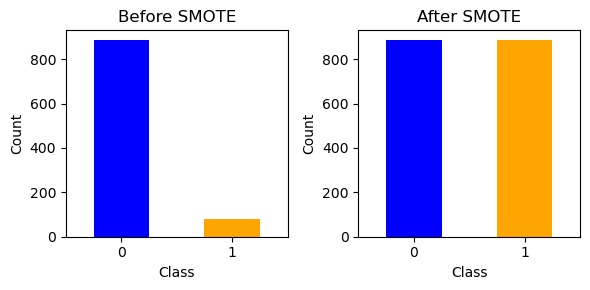

In [43]:
new_class_counts = y_resampled.value_counts()
new_class_counts = new_class_counts.sort_index()

# Visualize change in class imbalance
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
old_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
new_class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Train/test split

In [44]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=28)

### Exploring a Basic NN

In [45]:
# Define the neural network model
model = Sequential([
    Dense(128, 
          activation='relu', 
          input_shape=(768,),
          kernel_initializer='he_normal', 
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64, 
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1, 
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [46]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01)#, use_ema=True, ema_momentum=0.9)
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.99, nesterov=True)
#opt = tf.keras.optimizers.Adadelta(learning_rate=0.01, use_ema=True, ema_momentum=0.99)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy']) 

In [47]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_split=0.2)

Epoch 1/15
71/71 [==============================] - 2s 25ms/step - loss: 4.4715 - accuracy: 0.5146 - val_loss: 4.2186 - val_accuracy: 0.5915
Epoch 2/15
71/71 [==============================] - 1s 14ms/step - loss: 3.9022 - accuracy: 0.6117 - val_loss: 3.5506 - val_accuracy: 0.6408
Epoch 3/15
71/71 [==============================] - 1s 13ms/step - loss: 3.2223 - accuracy: 0.6452 - val_loss: 2.9073 - val_accuracy: 0.6373
Epoch 4/15
71/71 [==============================] - 1s 13ms/step - loss: 2.5956 - accuracy: 0.6611 - val_loss: 2.3593 - val_accuracy: 0.6303
Epoch 5/15
71/71 [==============================] - 1s 13ms/step - loss: 2.0424 - accuracy: 0.7087 - val_loss: 1.8148 - val_accuracy: 0.7183
Epoch 6/15
71/71 [==============================] - 1s 13ms/step - loss: 1.6027 - accuracy: 0.7538 - val_loss: 1.4370 - val_accuracy: 0.7535
Epoch 7/15
71/71 [==============================] - 1s 13ms/step - loss: 1.2615 - accuracy: 0.7891 - val_loss: 1.1590 - val_accuracy: 0.7782
Epoch 8/15
71

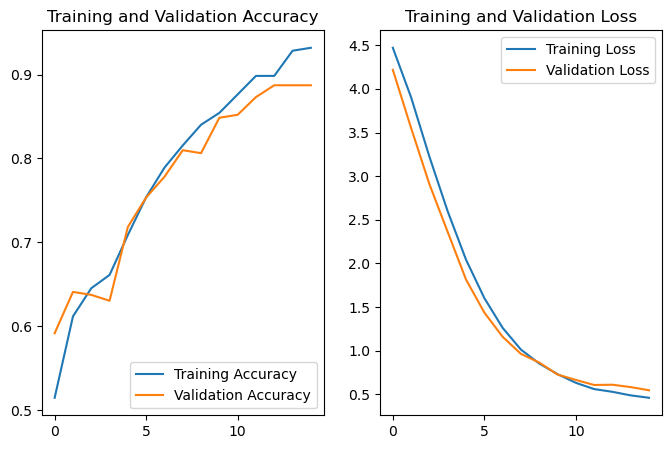

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

12/12 [==============================] - 0s 18ms/step
AUC-ROC Score: 0.944
F1-Score: 0.9047619047619048


---

# Comments on model results:

These results possibly indicate that there are discernible patterns in the text of US presidential speeches that correlate with the US entering a major war  within one year of the speech. This (I think) suggests that Presidents leverage certain language or rhetorical cues in their speeches to prepare the nation for war.

# Next Steps:

Professor mentioned that it would be interesting if we can try to identify discriminative features between the two classes (i.e., Interpretable Learning). So, see if we could answer questions like: What is the model seeing in the speech that makes it classify it as leading up to war or what is missing in the other class that makes it classify that way?

To tackle this we might consider:

### __1__: Layer-wise Relevance Propagation (LRP):

Implement LRP to understand the relevance of input features to the model's predictions. This can help us identify which words or phrases in the speeches contribute most significantly to the classification decision.

### __2__: SHAP (SHapley Additive exPlanations):

Use SHAP values to compute the importance of each feature in the context of individual predictions. This technique will provide insights into how each feature influences the model's output.

### __3__: Feature Importance Scores:

After training your model, extract the weights of the first layer (Dense(128)) and analyze which input features have the highest weights. This can give us an idea of which words or phrases are most influential in determining the classification.

### __4__: Attention Mechanisms:

If applicable, incorporate attention mechanisms into your model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __5__: Word Embedding Visualization:

Visualize word embeddings to understand how words are represented in the model's embedding space. This can help us identify clusters of words associated with specific classes (e.g., words related to war).

### __6__: Grad-CAM (Gradient-weighted Class Activation Mapping):

If we use a model architecture with convolutional layers, we might consider apply Grad-CAM to visualize which parts of the input text are most important for the model's predictions. This technique highlights regions of the input that contribute most to the final decision.